# Test AGM-TE on electrophysiological data from the Allen Institute for Brain Science

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from itertools import permutations

from agm_te.dataset import DataSet
from agm_te.estimate import init_agms_from_loaders, train_agms, _TE_from_losses

In [2]:
import torch; torch.set_printoptions(sci_mode=None)
# Check if CUDA is available
if torch.cuda.is_available():
    compute_device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    compute_device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU.


### General Dataset Information

In [3]:
areas_list = ['V1', 'RL', 'LM', 'AL', 'PM', 'AM']
areas_index = [0, 1, 2, 3, 4, 5]

index_combinations = list(permutations(areas_index, 2))
print('there are ',len(index_combinations), 'combinations of areas in the Allen dataset for which we can compute the CTE')

there are  30 combinations of areas in the Allen dataset for which we can compute the CTE


In [4]:
valid_sessions = [719161530, 750332458, 750749662, 754312389, 755434585, 756029989, 791319847, 797828357]

In [5]:
for valid_session in valid_sessions:
    allen_datadict_cleaned = {'V1': [], 'RL': [], 'LM': [], 'AL': [], 'PM': [], 'AM': []}
    # load the data
    allen_datadict = pickle.load(open(f'Timeseries/bck/session_{valid_session}_100ms.pkl', 'rb'))
    print("\n\n>>> Session ", valid_session, " <<<")
    
    for area in areas_list:
        temp = allen_datadict[area][0]
        total_spikes_per_neuron = np.zeros(temp.shape[1])
        for i in range(len(allen_datadict['V1'])):    
            temp = allen_datadict[area][i]
            total_spikes_per_neuron += np.sum(temp, axis=0)
        #print(total_spikes_per_neuron)
        for i in range(len(allen_datadict['V1'])):
            temp = allen_datadict[area][i]
            boolmask = total_spikes_per_neuron > 1000
            temp = temp[:, boolmask]
            allen_datadict_cleaned[area].append(temp)
    
    # create the dataset
    dataset = DataSet(allen_datadict_cleaned)
    print(dataset)



>>> Session  719161530  <<<
DataSet of 16000 timesteps across 16 trajectories for 6 variables:
	 V1 is 49 dimensional
	 RL is 7 dimensional
	 LM is 39 dimensional
	 AL is 9 dimensional
	 PM is 18 dimensional
	 AM is 33 dimensional



>>> Session  750332458  <<<
DataSet of 15000 timesteps across 15 trajectories for 6 variables:
	 V1 is 57 dimensional
	 RL is 39 dimensional
	 LM is 36 dimensional
	 AL is 63 dimensional
	 PM is 17 dimensional
	 AM is 57 dimensional



>>> Session  750749662  <<<
DataSet of 15000 timesteps across 15 trajectories for 6 variables:
	 V1 is 52 dimensional
	 RL is 39 dimensional
	 LM is 19 dimensional
	 AL is 46 dimensional
	 PM is 62 dimensional
	 AM is 61 dimensional



>>> Session  754312389  <<<
DataSet of 18000 timesteps across 18 trajectories for 6 variables:
	 V1 is 90 dimensional
	 RL is 40 dimensional
	 LM is 13 dimensional
	 AL is 31 dimensional
	 PM is 21 dimensional
	 AM is 58 dimensional



>>> Session  755434585  <<<
DataSet of 15000 timesteps a

## Estimate CTE across the 6 anatomical areas

In [6]:
EPOCHS = 10000
HIDDEN_SIZE = 50

In [7]:
CTE_tables = []

# Three repetitions of the estimation
for r in range(3):
    
    # Iterate over the 8 experimenal sessions
    for valid_session in valid_sessions:
        
        # Load the timeseries data
        allen_datadict = pickle.load(open(f'timeseries_data/session_{valid_session}_100ms.pkl', 'rb'))
        print("\n\n>>> Session ", valid_session, " <<<")
        allen_dataset = DataSet(allen_datadict)
        print(allen_dataset)

        # Perform CTE estimation
        CTE_table = np.zeros((len(areas_list), len(areas_list)))
        for var_from_idx, var_to_idx in index_combinations:
            var_from = areas_list[var_from_idx]
            var_to = areas_list[var_to_idx]

            data_dim = allen_dataset.data[var_to][0].shape[1]

            print(f"\n>> Estimating CTE from {var_from} to {var_to} <<")

            # Initialize AGMs
            dataloader_1, dataloader_2 = allen_dataset.get_CTE_dataloaders(var_from=var_from, var_to=var_to, var_cond='remaining')
            model_1, model_2 = init_agms_from_loaders(
                dataloader_1, dataloader_2, 
                hidden_size=HIDDEN_SIZE, 
                rnn_type='GRU', 
                model_type='poisson', 
                timestep = 0.1
                )
            
            model_1 = model_1.to(compute_device)
            model_2 = model_2.to(compute_device)
            
            # Train AGMs
            model_1, loss_1, model_2, loss_2 = train_agms(
                model_1, dataloader_1, model_2, dataloader_2, 
                batch_size=allen_dataset.n_traj, 
                epochs=EPOCHS, 
                learning_rate=0.001, 
                optimize='adam', 
                lr_decay_gamma=0.90, 
                plot_loss=False
                )
            
            # Compute Conditional Transfer Entropy
            CTE = round(_TE_from_losses(loss_1, loss_2), 2)
            CTE_table[var_to_idx, var_from_idx] = CTE

            print(f"> CTE from {var_from} to {var_to}: {CTE} <")

        print(CTE_table)
        CTE_tables.append(CTE_table)



>>> Session  719161530  <<<
DataSet of 16000 timesteps across 16 trajectories for 6 variables:
	 V1 is 52 dimensional
	 LM is 40 dimensional
	 RL is 10 dimensional
	 AL is 9 dimensional
	 PM is 18 dimensional
	 AM is 37 dimensional


>> Estimating CTE from V1 to RL <<
Loss 1: 2.874889, Loss 2: 2.630973, Est. TE: 0.2439
> CTE from V1 to RL: 0.24 <

>> Estimating CTE from V1 to LM <<
Loss 1: 10.662548, Loss 2: 10.280297, Est. TE: 0.3823
> CTE from V1 to LM: 0.38 <

>> Estimating CTE from V1 to AL <<
Loss 1: -0.786406, Loss 2: -1.071923, Est. TE: 0.2855
> CTE from V1 to AL: 0.29 <

>> Estimating CTE from V1 to PM <<
Loss 1: 6.372926, Loss 2: 6.024893, Est. TE: 0.348
> CTE from V1 to PM: 0.35 <

>> Estimating CTE from V1 to AM <<
Loss 1: 6.827367, Loss 2: 6.390355, Est. TE: 0.437
> CTE from V1 to AM: 0.44 <

>> Estimating CTE from RL to V1 <<
Loss 1: 6.582566, Loss 2: 6.38907, Est. TE: 0.1935
> CTE from RL to V1: 0.19 <

>> Estimating CTE from RL to LM <<
Loss 1: 10.155825, Loss 2: 10.10

[[0.   0.33 0.39 0.36 0.38 0.55]
 [0.34 0.   0.23 0.14 0.24 0.32]
 [0.38 0.18 0.   0.19 0.18 0.33]
 [0.39 0.24 0.19 0.   0.21 0.35]
 [0.36 0.21 0.15 0.22 0.   0.31]
 [0.39 0.3  0.17 0.35 0.26 0.  ]]


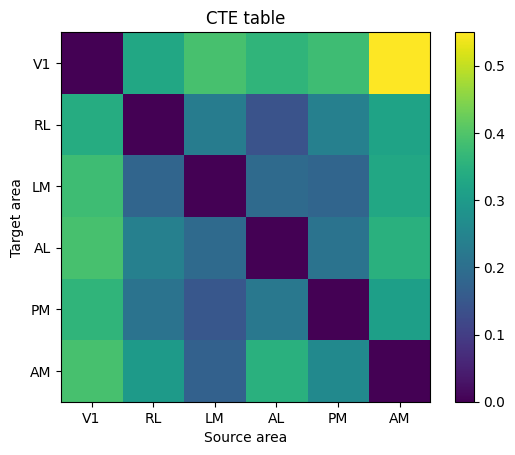

In [10]:
avg_CTE_table = np.mean(CTE_tables, axis=0)
avg_CTE_table = np.round(avg_CTE_table, 2)
avg_CTE_table = np.clip(avg_CTE_table, 0, None)
print(avg_CTE_table)
plt.imshow(avg_CTE_table, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.xticks(areas_index, areas_list)
plt.yticks(areas_index, areas_list)
plt.title('CTE table')
plt.ylabel('Target area')
plt.xlabel('Source area')
plt.show()

In [9]:
# Use pickle.dump() to serialize the dictionary and write it to the file
with open(f'inferred_EC_matrices.pkl', 'wb') as file:
    pickle.dump(CTE_tables, file)